In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Jan 19 19:00:19 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   45C    P0    69W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.dalle_encoder import Encoder
from model.prior.multi_randn_prior import Prior
from model.latent.dalle_multi_lse_latent import Latent
from model.quantizer.dalle_nearest_multi_quantizer import Quantizer
from model.decoder.dalle_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 256
hp.n_blk_per_group = 2
hp.n_hid = 128
hp.n_latents = 13
hp.dim_per_latent = 16
hp.z_dim = hp.n_latents * hp.dim_per_latent
hp.n_prior_embeddings = 2
hp.init_log_sigma = -1
hp.const_sigma = True

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 36.15240478515625
encoder.encoder 36.15240478515625
prior 0.0015869140625
latent 3.814697265625e-06
quantizer 0.0
decoder 41.2302360534668
decoder.decoder 41.2302360534668
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 2195, model_list, optimizer_list)

total 239096
-rw-rw-r-- 1 scpark scpark        40  1월 19 19:00 events.out.tfevents.1705658405.GPUSVR11
-rw-rw-r-- 1 scpark scpark    329444  1월 19 18:59 events.out.tfevents.1705658112.GPUSVR11
-rw-rw-r-- 1 scpark scpark 243615153  1월 19 18:55 save_0
-rw-rw-r-- 1 scpark scpark        40  1월 19 18:54 events.out.tfevents.1705658034.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 19 18:53 events.out.tfevents.1705657979.GPUSVR11
-rw-rw-r-- 1 scpark scpark     69764  1월 19 18:52 events.out.tfevents.1705657898.GPUSVR11
-rw-rw-r-- 1 scpark scpark    517316  1월 19 18:51 events.out.tfevents.1705657434.GPUSVR11
-rw-rw-r-- 1 scpark scpark    222884  1월 19 18:43 events.out.tfevents.1705657076.GPUSVR11
-rw-rw-r-- 1 scpark scpark     16351  1월 19 18:37 events.out.tfevents.1705657007.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 19 18:36 events.out.tfevents.1705656986.GPUSVR11
-rw-rw-r-- 1 scpark scpark        40  1월 19 18:36 events.out.tfevents.1705656751.GPUSVR11
-rw-rw-r-- 1 scpark scpark    

### Dataset

In [7]:
from torch.utils.data import DataLoader, Dataset
from data.imagenet_dataset import ImagenetDataset

train_data_dir = '/data/imagenet/val'
train_dataset = ImagenetDataset(root_dir=train_data_dir, img_size=hp.img_size)
train_loader = DataLoader(train_dataset, batch_size=16,
                              shuffle=True, num_workers=1)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

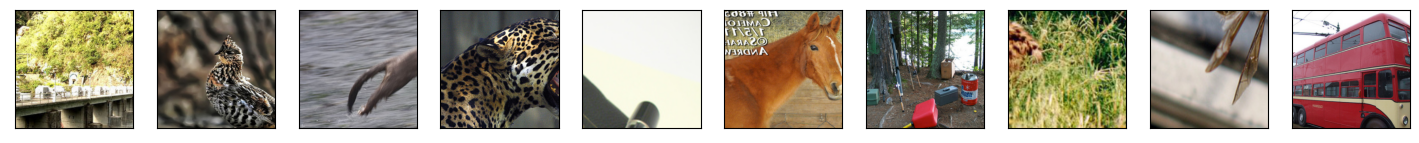

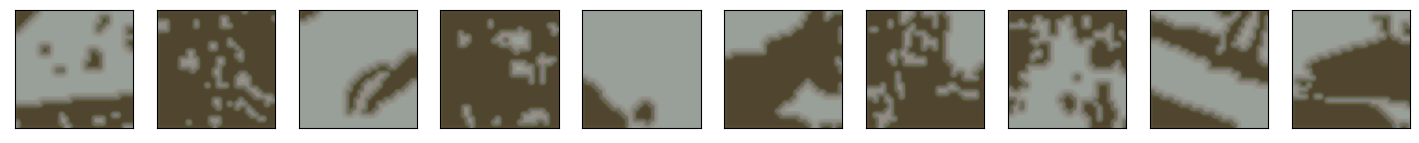

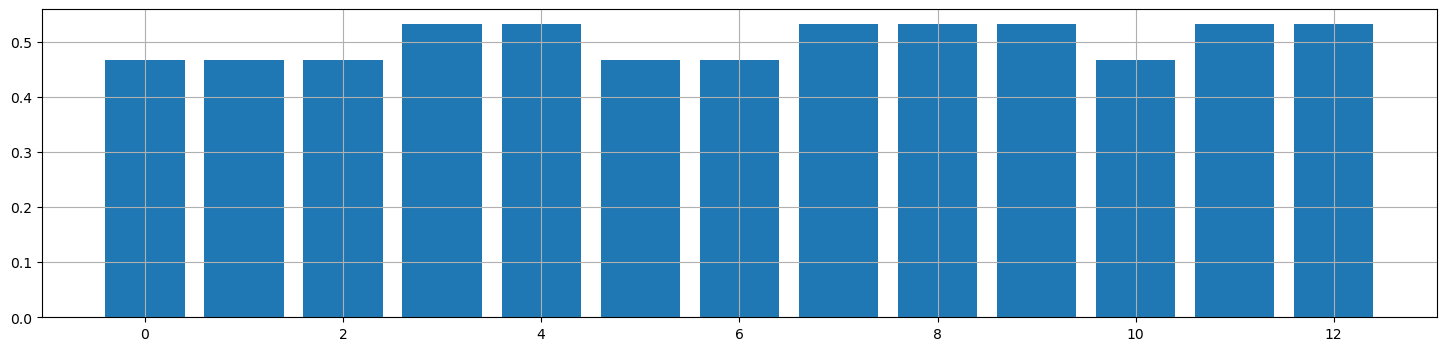

1001
lse_loss -311.274658203125
recon_loss 0.03701534494757652
1002
lse_loss -311.268310546875
recon_loss 0.04444674775004387
1003
lse_loss -311.2642822265625
recon_loss 0.04240890592336655
1004
lse_loss -311.27130126953125
recon_loss 0.05123127996921539
1005
lse_loss -311.27984619140625
recon_loss 0.05401592701673508
1006
lse_loss -311.2627258300781
recon_loss 0.04295657202601433
1007
lse_loss -311.2809143066406
recon_loss 0.041280023753643036
1008
lse_loss -311.2384948730469
recon_loss 0.03749844804406166
1009
lse_loss -311.2805480957031
recon_loss 0.033432312309741974
1010
lse_loss -311.2724304199219
recon_loss 0.0295046865940094
1011
lse_loss -311.2424011230469
recon_loss 0.04162084311246872
1012
lse_loss -311.18389892578125
recon_loss 0.05465806648135185
1013
lse_loss -311.2491149902344
recon_loss 0.04574074596166611
1014
lse_loss -311.1637268066406
recon_loss 0.02959662675857544
1015
lse_loss -311.11859130859375
recon_loss 0.04640284180641174
1016
lse_loss -311.19366455078125
rec

lse_loss -311.2885437011719
recon_loss 0.04140343889594078
1130
lse_loss -311.2243957519531
recon_loss 0.041974809020757675
1131
lse_loss -311.2170715332031
recon_loss 0.035271670669317245
1132
lse_loss -311.2776184082031
recon_loss 0.030196845531463623
1133
lse_loss -311.2787780761719
recon_loss 0.0410180389881134
1134
lse_loss -311.25433349609375
recon_loss 0.03689780831336975
1135
lse_loss -311.25982666015625
recon_loss 0.03339391574263573
1136
lse_loss -311.2642517089844
recon_loss 0.03743811696767807
1137
lse_loss -311.2787170410156
recon_loss 0.03722715005278587
1138
lse_loss -311.28570556640625
recon_loss 0.03448911011219025
1139
lse_loss -311.285400390625
recon_loss 0.04352127015590668
1140
lse_loss -311.27398681640625
recon_loss 0.035834528505802155
1141
lse_loss -311.2809143066406
recon_loss 0.03253350034356117
1142
lse_loss -311.285400390625
recon_loss 0.03395967558026314
1143
lse_loss -311.28521728515625
recon_loss 0.03712485730648041
1144
lse_loss -311.2375183105469
recon_

lse_loss -311.2940979003906
recon_loss 0.030811097472906113
1258
lse_loss -311.2795104980469
recon_loss 0.03599567711353302
1259
lse_loss -311.28759765625
recon_loss 0.03627655655145645
1260
lse_loss -311.2930908203125
recon_loss 0.036314453929662704
1261
lse_loss -311.2912292480469
recon_loss 0.032144419848918915
1262
lse_loss -311.2723388671875
recon_loss 0.03457024693489075
1263
lse_loss -311.26007080078125
recon_loss 0.02617383562028408
1264
lse_loss -311.29736328125
recon_loss 0.032312121242284775
1265
lse_loss -311.274658203125
recon_loss 0.026761531829833984
1266
lse_loss -311.26434326171875
recon_loss 0.03480301797389984
1267
lse_loss -311.2858581542969
recon_loss 0.0347074419260025
1268
lse_loss -311.2274475097656
recon_loss 0.04811429977416992
1269
lse_loss -311.2917175292969
recon_loss 0.038378309458494186
1270
lse_loss -311.26727294921875
recon_loss 0.035661209374666214
1271
lse_loss -311.2335510253906
recon_loss 0.03457827493548393
1272
lse_loss -311.27630615234375
recon_l

lse_loss -311.2745666503906
recon_loss 0.03396723046898842
1386
lse_loss -311.279052734375
recon_loss 0.03738239407539368
1387
lse_loss -311.2860412597656
recon_loss 0.029319345951080322
1388
lse_loss -311.2869873046875
recon_loss 0.027677899226546288
1389
lse_loss -311.2875671386719
recon_loss 0.0326063297688961
1390
lse_loss -311.2762756347656
recon_loss 0.04773616045713425
1391
lse_loss -311.1608581542969
recon_loss 0.03936820849776268
1392
lse_loss -311.20733642578125
recon_loss 0.03217069432139397
1393
lse_loss -311.2745056152344
recon_loss 0.039362385869026184
1394
lse_loss -311.2091979980469
recon_loss 0.035771310329437256
1395
lse_loss -311.2734069824219
recon_loss 0.05432114005088806
1396
lse_loss -311.2582092285156
recon_loss 0.03377607464790344
1397
lse_loss -311.279296875
recon_loss 0.03461772948503494
1398
lse_loss -311.2563171386719
recon_loss 0.03741272911429405
1399
lse_loss -311.2808532714844
recon_loss 0.03471336141228676
1400
lse_loss -311.18756103515625
recon_loss 0

lse_loss -311.2923278808594
recon_loss 0.04093407839536667
1514
lse_loss -311.2897644042969
recon_loss 0.04605923593044281
1515
lse_loss -311.28472900390625
recon_loss 0.0344235897064209
1516
lse_loss -311.2413024902344
recon_loss 0.03515474498271942
1517
lse_loss -311.2665100097656
recon_loss 0.04115806519985199
1518
lse_loss -311.2941589355469
recon_loss 0.037011198699474335
1519
lse_loss -311.2880859375
recon_loss 0.046410948038101196
1520
lse_loss -311.28466796875
recon_loss 0.03337542340159416
1521
lse_loss -311.287841796875
recon_loss 0.029873698949813843
1522
lse_loss -311.28570556640625
recon_loss 0.037258125841617584
1523
lse_loss -311.2518615722656
recon_loss 0.037110570818185806
1524
lse_loss -311.2640380859375
recon_loss 0.033727362751960754
1525
lse_loss -311.2523498535156
recon_loss 0.03660494089126587
1526
lse_loss -311.2866516113281
recon_loss 0.04482390731573105
1527
lse_loss -311.2667541503906
recon_loss 0.03713405877351761
1528
lse_loss -311.2638244628906
recon_loss 

lse_loss -311.2937316894531
recon_loss 0.04367419332265854
1642
lse_loss -311.2950744628906
recon_loss 0.03743106871843338
1643
lse_loss -311.2928161621094
recon_loss 0.038883354514837265
1644
lse_loss -311.2553405761719
recon_loss 0.036303527653217316
1645
lse_loss -311.2565612792969
recon_loss 0.03868292272090912
1646
lse_loss -311.29156494140625
recon_loss 0.037692051380872726
1647
lse_loss -311.2888488769531
recon_loss 0.035442955791950226
1648
lse_loss -311.25872802734375
recon_loss 0.031703703105449677
1649
lse_loss -311.2961120605469
recon_loss 0.02766263484954834
1650
lse_loss -311.29425048828125
recon_loss 0.03469889611005783
1651
lse_loss -311.2680358886719
recon_loss 0.039829470217227936
1652
lse_loss -311.27716064453125
recon_loss 0.036669664084911346
1653
lse_loss -311.2547302246094
recon_loss 0.03761052340269089
1654
lse_loss -311.229248046875
recon_loss 0.04203919693827629
1655
lse_loss -311.2660827636719
recon_loss 0.04019826650619507
1656
lse_loss -311.2714538574219
re

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            min_indices = data['min_indices'].reshape(hp.n_latents, -1)
            ratios = []
            for i in range(hp.n_latents):
                ratio = sum(min_indices[i]) / len(min_indices[i])
                ratios.append(ratio.item())

            plt.figure(figsize=[18, 4])
            plt.bar([i for i in range(len(ratios))], ratios)
            plt.grid()
            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')